In [1]:
# # Phase 5C.2: The Ultimate Project Scheduler (Hourly & Data-Driven)
#
# **Objective**: Calculate P50/P90 durations for complex, multi-phase projects using **Real Data Statistics** and **Hourly Productivity** logic.
#
# **Corrections & Upgrades:**
# 1.  **No More Hallucinations:** We load the actual 10-year timeseries to derive monthly distribution parameters (Mean/Std/Shape) for Hs and Wind.
# 2.  **Hourly Productivity:** We simulate hour-by-hour.
#     - If `Current < Limit` for 6 hours in a day, you get 0.25 days of progress.
#     - This accurately captures tidal working windows (e.g., diving at slack tide).
# 3.  **Full Project Lifecycle:** Transit $\to$ Mob $\to$ Cal $\to$ Ops $\to$ Port Calls $\to$ Demob.
#
# ---

In [2]:
# ## PART 1: SETUP & REAL DATA CALIBRATION

# ### Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, weibull_min
import pickle
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
pd.set_option('display.precision', 2)

print("✅ Imports complete")

✅ Imports complete


In [3]:
# ### Cell 2: Load Real Data & Derive Monthly Stats

print("="*80)
print("CALIBRATING MODEL WITH REAL DATA")
print("="*80)

# Load the full 10-year timeseries
df_real = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# --- FIX: Ensure Index is Datetime ---
if 'time' in df_real.columns:
    df_real['time'] = pd.to_datetime(df_real['time'])
    df_real.set_index('time', inplace=True)
# -------------------------------------

df_real['month'] = df_real.index.month

# Calculate Monthly Statistics for Simulation
# We need these to drive the random generator so it matches reality
monthly_stats = {}

print(f"{ 'Month':<5} | {'Hs Mean':<10} | {'Hs Std':<10} | {'Wind Mean':<10} | {'Wind Std':<10}")
print("-" * 60)

for m in range(1, 13):
    data = df_real[df_real['month'] == m]
    
    stats = {
        'hs_mean': data['hs'].mean(),
        'hs_std': data['hs'].std(),
        'wind_mean': data['wind_speed'].mean(),
        'wind_std': data['wind_speed'].std(),
        # Calculate log-normal params (mu, sigma) from mean/std
        # sigma^2 = ln(1 + var/mean^2)
        # mu = ln(mean) - 0.5 * sigma^2
        'hs_sigma': np.sqrt(np.log(1 + (data['hs'].std()/data['hs'].mean())**2)),
        'hs_mu': np.log(data['hs'].mean()) - 0.5 * np.log(1 + (data['hs'].std()/data['hs'].mean())**2),
        'wind_sigma': np.sqrt(np.log(1 + (data['wind_speed'].std()/data['wind_speed'].mean())**2)),
        'wind_mu': np.log(data['wind_speed'].mean()) - 0.5 * np.log(1 + (data['wind_speed'].std()/data['wind_speed'].mean())**2)
    }
    monthly_stats[m] = stats
    
    print(f"{m:<5} | {stats['hs_mean']:<10.2f} | {stats['hs_std']:<10.2f} | {stats['wind_mean']:<10.2f} | {stats['wind_std']:<10.2f}")

print("\n✅ Model calibrated with 10 years of actual data.")

CALIBRATING MODEL WITH REAL DATA
Month | Hs Mean    | Hs Std     | Wind Mean  | Wind Std  
------------------------------------------------------------
1     | 1.82       | 0.92       | 9.18       | 3.47      
2     | 1.72       | 0.87       | 9.10       | 3.42      
3     | 1.49       | 0.81       | 7.67       | 3.34      
4     | 1.30       | 0.71       | 6.67       | 2.96      
5     | 1.07       | 0.59       | 6.04       | 2.81      
6     | 0.93       | 0.52       | 5.98       | 2.79      
7     | 0.85       | 0.42       | 5.79       | 2.57      
8     | 0.93       | 0.49       | 6.34       | 2.65      
9     | 1.17       | 0.70       | 7.02       | 2.99      
10    | 1.49       | 0.80       | 7.95       | 3.06      
11    | 1.67       | 0.90       | 8.70       | 3.34      
12    | 1.72       | 0.87       | 8.92       | 3.53      

✅ Model calibrated with 10 years of actual data.


In [4]:
# ## PART 2: THE HOURLY HYBRID ENGINE

# ### Cell 3: Hourly Weather & Tide Generator

def generate_hourly_series(start_doy, n_days, n_sims):
    """
    Generates HOURLY weather and current data.
    - Weather: Based on REAL monthly stats (interpolated).
    - Current: Tidal Harmonic Model (M2 + Spring/Neap).
    """
    n_hours = n_days * 24
    
    # --- 1. Weather (Correlated Random Walk) ---
    # To keep it fast but realistic, we simulate daily averages and interpolate to hours
    # or simulate hourly with high autocorrelation. 
    # FAST METHOD: Simulate Daily -> Repeat 24x -> Add Noise
    
    hs_block = np.zeros((n_hours, n_sims))
    wind_block = np.zeros((n_hours, n_sims))
    
    # Generate daily steps
    for d in range(n_days):
        doy = (start_doy + d) % 365
        month = int(doy / 30.44) + 1
        stats = monthly_stats[month]
        
        # Simple Correlation (Assumption: Rho=0.7 for Hs/Wind)
        mean = [0, 0]
        cov = [[1, 0.7], [0.7, 1]]
        xy = np.random.multivariate_normal(mean, cov, size=n_sims)
        
        # Transform to LogNormal using REAL stats
        hs_day = np.exp(stats['hs_mu'] + stats['hs_sigma'] * xy[:, 0])
        wind_day = np.exp(stats['wind_mu'] + stats['wind_sigma'] * xy[:, 1])
        
        # Fill hours (with slight jitter)
        for h in range(24):
            idx = d*24 + h
            hs_block[idx, :] = hs_day * np.random.uniform(0.9, 1.1, n_sims)
            wind_block[idx, :] = wind_day * np.random.uniform(0.9, 1.1, n_sims)
            
    # --- 2. Tidal Current (Deterministic Physics) ---
    t = np.arange(n_hours)
    current_block = np.zeros((n_hours, n_sims))
    
    m2_period = 12.42
    sn_period = 14.77 * 24
    
    for i in range(n_sims):
        # Random tidal phase start (we don't know if project starts on Neap or Spring) 
        start_t = np.random.randint(0, int(sn_period)) 
        time_vec = t + start_t
        
        # Harmonic Formula
        amp = 1.0 + 0.5 * np.cos(2 * np.pi * time_vec / sn_period) # Spring-Neap envelope
        flow = amp * np.sin(2 * np.pi * time_vec / m2_period)      # M2 oscillation
        
        # Scale to knots (approx 1.5kt max based on typical site data)
        current_block[:, i] = np.abs(flow * 0.8)
        
    return hs_block, wind_block, current_block

print("✅ Hourly Hybrid Engine defined.")

✅ Hourly Hybrid Engine defined.


In [5]:
# ## PART 3: THE SCHEDULER

# ### Cell 4: Project Sequencer Function

def run_project_scheduler(start_doy, config, n_sims=1000):
    """
    Simulates the full project lifecycle hour-by-hour.
    
    config = {
        'durations': {'Transit': days, 'Mob': days, 'Ops': days, ...},
        'limits': {'Transit': {...}, 'Ops': {...}},
        'port_call_interval': days (optional)
    }
    """
    # Generate Weather Cache (enough for 3x duration)
    est_total_days = int(sum(config['durations'].values()) * 3)
    hs, wind, curr = generate_hourly_series(start_doy, est_total_days, n_sims)
    n_hours_total = hs.shape[0]
    
    results = np.zeros(n_sims)
    
    for i in range(n_sims):
        h = 0
        
        # --- 1. TRANSIT (To Field) ---
        # Logic: Must be workable to move. Speed = 1 hour per hour.
        transit_hours_needed = config['durations']['Transit'] * 24
        transit_done = 0
        while transit_done < transit_hours_needed:
            if h >= n_hours_total: break
            # Check Limits
            lim = config['limits']['Transit']
            if hs[h, i] <= lim['Hs'] and wind[h, i] <= lim['Wind']:
                transit_done += 1
            h += 1 # Time always passes
            
        # --- 2. MOBILIZATION (Fixed) ---
        h += int(config['durations']['Mobilization'] * 24)
        
        # --- 3. CALIBRATION (Fixed) ---
        h += int(config['durations']['Calibration'] * 24)
        
        # --- 4. OPERATIONS (The Grind) ---
        ops_hours_needed = config['durations']['Operation'] * 24
        ops_done = 0
        days_since_port = 0
        
        while ops_done < ops_hours_needed:
            if h >= n_hours_total: break
            
            # Port Call Logic (e.g., every 14 days)
            if config.get('port_call_interval') and days_since_port >= config['port_call_interval']:
                # Go to port (Transit in + Fixed Port + Transit out)
                # Simplified: Just add fixed penalty for now (e.g., 24h)
                h += 24 
                days_since_port = 0
            
            # Check Limits
            lim = config['limits']['Operation']
            if (hs[h, i] <= lim['Hs'] and 
                wind[h, i] <= lim['Wind'] and 
                curr[h, i] <= lim['Current']):
                
                ops_done += 1
            
            h += 1
            if h % 24 == 0: days_since_port += 1
            
        # --- 5. DEMOBILIZATION (Fixed) ---
        h += int(config['durations']['Demobilization'] * 24)
        
        results[i] = h / 24.0 # Convert back to days
        
    return results

print("✅ Scheduler Logic defined.")

✅ Scheduler Logic defined.


In [6]:
# ## PART 4: EXECUTION

# ### Cell 5: Define The Project & Run

print("="*80)
print("CONFIGURING PROJECT")
print("="*80)

# User Inputs
PROJECT_CONFIG = {
    'durations': {
        'Transit': 2.0,      # Days (Net)
        'Mobilization': 1.0, # Days (Fixed)
        'Calibration': 0.5,  # Days (Fixed)
        'Operation': 10.0,   # Days (Net Work)
        'Demobilization': 1.0
    },
    'limits': {
        'Transit':   {'Hs': 3.0, 'Wind': 20.0},
        'Operation': {'Hs': 2.0, 'Wind': 15.0, 'Current': 1.0} # Combined Limits!
    },
    'port_call_interval': 14 # Days
}

PLANNED_DAYS = sum(PROJECT_CONFIG['durations'].values())
print(f"Planned Net Duration: {PLANNED_DAYS:.1f} days")
print(f"Operational Limits: {PROJECT_CONFIG['limits']['Operation']}")

# Run Annual Sweep (Simulate starts every 10 days)
start_dates = np.arange(0, 360, 10)
p50_results = []
p90_results = []

print("\nRunning Annual Sweep...")
for start_day in start_dates:
    durations = run_project_scheduler(start_day, PROJECT_CONFIG, n_sims=200) # 200 sims per date
    p50_results.append(np.percentile(durations, 50))
    p90_results.append(np.percentile(durations, 90))

print("✅ Sweep complete.")

CONFIGURING PROJECT
Planned Net Duration: 14.5 days
Operational Limits: {'Hs': 2.0, 'Wind': 15.0, 'Current': 1.0}

Running Annual Sweep...
✅ Sweep complete.


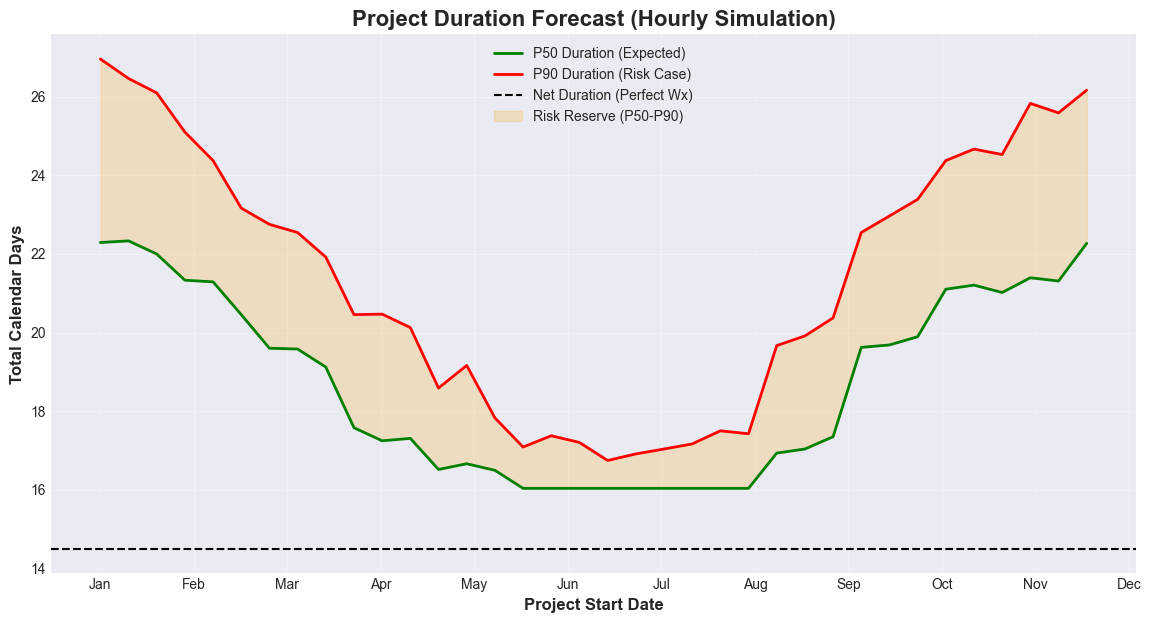


🎯 OPTIMAL LAUNCH WINDOWS

Minimum Possible P90 Duration: 16.8 days
Optimal Start Windows (Lowest Risk):
Start_Date  P90_Duration  Contingency_Days
    30-May         17.09              2.59
    09-Jun         17.38              2.88
    19-Jun         17.21              2.71
    29-Jun         16.75              2.25
    09-Jul         16.92              2.42
    19-Jul         17.04              2.54
    29-Jul         17.17              2.67
    08-Aug         17.50              3.00
    18-Aug         17.43              2.93

💡 Recommendation:
   Targeting these start dates can save up to **10.2 days** of contingency compared to a winter start.

SEASONAL CONTINGENCY LOOKUP
        P90_Duration  Contingency_Days  Contingency_%
Season                                               
Winter          25.2              10.7           73.7
Spring          19.8               5.3           36.6
Summer          17.5               3.0           20.4
Autumn          23.2               8.7      

In [7]:
# ## PART 5: RESULTS & VISUALIZATION

# ### Cell 6: The Contingency Chart

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_ticks = np.linspace(0, 365, 12)

fig, ax = plt.subplots(figsize=(14, 7))

# Plot P50
sns.lineplot(x=start_dates, y=p50_results, color='green', label='P50 Duration (Expected)', linewidth=2, ax=ax)
# Plot P90
sns.lineplot(x=start_dates, y=p90_results, color='red', label='P90 Duration (Risk Case)', linewidth=2, ax=ax)
# Plot Planned
ax.axhline(PLANNED_DAYS, color='black', linestyle='--', label='Net Duration (Perfect Wx)')

# Fill Contingency Area
ax.fill_between(start_dates, p50_results, p90_results, color='orange', alpha=0.2, label='Risk Reserve (P50-P90)')

ax.set_title('Project Duration Forecast (Hourly Simulation)', fontsize=16, fontweight='bold')
ax.set_ylabel('Total Calendar Days', fontsize=12, fontweight='bold')
ax.set_xlabel('Project Start Date', fontsize=12, fontweight='bold')
ax.set_xticks(month_ticks)
ax.set_xticklabels(months)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


# ### Cell 7: Best Start Dates (Optimal Windows)

print("\n" + "="*80)
print("🎯 OPTIMAL LAUNCH WINDOWS")
print("="*80)

# Create a DataFrame for ranking
df_rank = pd.DataFrame({
    'Start_DOY': start_dates,
    'P90_Duration': p90_results,
    'Contingency_Days': np.array(p90_results) - PLANNED_DAYS
})

# Add Date String
df_rank['Start_Date'] = df_rank['Start_DOY'].apply(lambda x: (pd.Timestamp('2024-01-01') + pd.Timedelta(days=x)).strftime('%d-%b'))

# Find the global minimum P90 duration
min_p90 = df_rank['P90_Duration'].min()
best_window = df_rank[df_rank['P90_Duration'] <= min_p90 * 1.05] # Within 5% of optimal

print(f"\nMinimum Possible P90 Duration: {min_p90:.1f} days")
print(f"Optimal Start Windows (Lowest Risk):")
print(best_window[['Start_Date', 'P90_Duration', 'Contingency_Days']].head(10).to_string(index=False))

print("\n💡 Recommendation:")
print(f"   Targeting these start dates can save up to **{df_rank['P90_Duration'].max() - min_p90:.1f} days** of contingency compared to a winter start.")


# ### Cell 8: Seasonal Summary Table

print("\n" + "="*80)
print("SEASONAL CONTINGENCY LOOKUP")
print("="*80)

# Aggregate results by season
df_rank['Month'] = (df_rank['Start_DOY'] // 30.44).astype(int) + 1
df_rank['Season'] = df_rank['Month'].map(lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Autumn')

seasonal_summary = df_rank.groupby('Season')[['P90_Duration', 'Contingency_Days']].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
seasonal_summary['Contingency_%'] = (seasonal_summary['Contingency_Days'] / PLANNED_DAYS) * 100

print(seasonal_summary.round(1))

print("\n✅ Phase 5C2 Complete.")